<a href="https://colab.research.google.com/github/Asura3301/Projects/blob/main/Micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

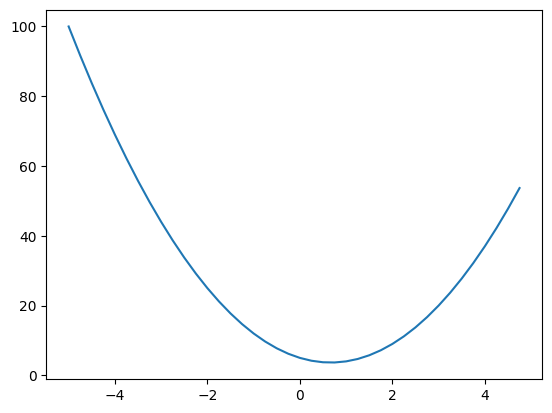

In [ ]:
plt.plot(xs, ys)

**Derivative - derivative is a fundamental tool that quantifies the sensitivity to change of a function's output with respect to its input.**

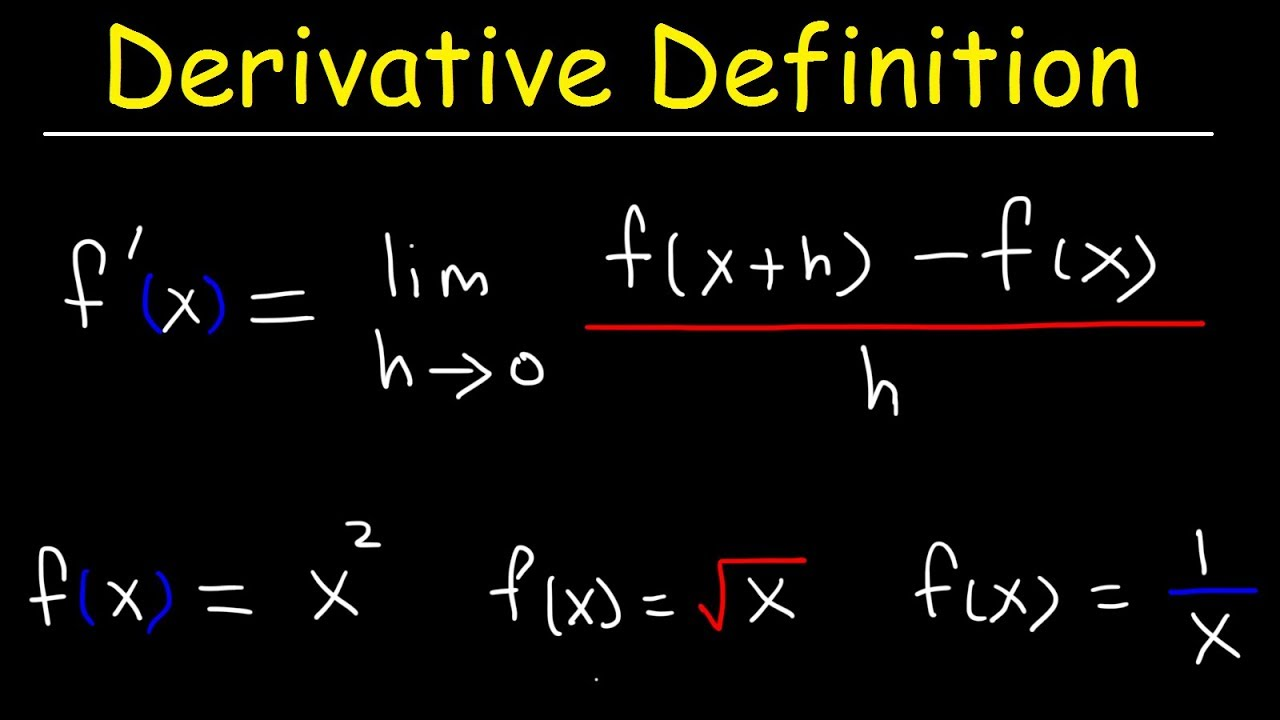

In [ ]:
h = 0.001
x = 3.0
f(x), f(x + h) # if we add a little scale into our function we can see that it become a little bit larger

(20.0, 20.014003000000002)

**The derivative of a function describes the function's instantaneous rate of change at a certain point. Another common interpretation is that the derivative gives us the slope of the line tangent to the function's graph at that point.**

In [ ]:
f(x + h) - f(x) # This is how much the function responded(in a positive direction)

0.01400300000000243

In [ ]:
(f(x + h) - f(x))/h # and we need to normalize it by run -> and then we get a "Slope"

14.00300000000243

In [ ]:
# lets get more complex case
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# a += h
# b += h
c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


1. **Starting Core Value object of MicroGrad**


a + b return error because python dont know how to add 2 value object so we have to tell him how


"a.__add__(b), a + b # the same representation"

"a.__mul__(b), a * b"


a*b + c # (a.__mul__(b)).__add__(c)

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children) # we will use as a set for efficiency
    self._op = _op   # operation sign of
    self.label = label

  # __repr__ providing us a way to print nicer looking expression in Python, and its not look like cryptic
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad # local derivative
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      # we should accumulate these gradients so we should "+=""
      self.grad += other.data * out.grad # local derivative
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()



a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"
L



Value(data=-8.0)

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

In [ ]:
d.label

'd'

In [ ]:
d.grad

0.0

2. **Lets draw a Computational Graph for visualization Backprpagation**


In [ ]:
from graphviz import Digraph

# helper function that enumarates all of the nodes in the graph
def trace(root):
  # building a set of all nodes and edges in graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) #LR - left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create rectangular ("record") node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

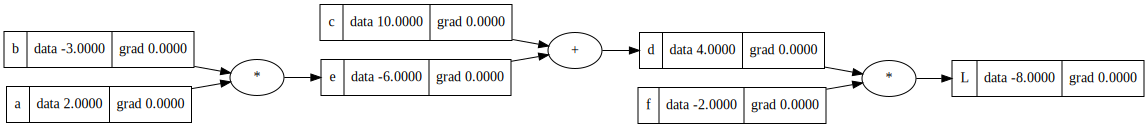

In [ ]:
draw_dot(L)

3. **Manually Backpropagation**

Backpropagation is just recursive application of Chain Rule backwards through the computational graph

**grad** - is gradient that representing the derivative of the output in this case "L" with recpect to other value


In [ ]:
def lol():

  # gating fucntion to prevent pollute and mess up to global scope(all of this variables are now local)

  h = 0.001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f; L.label = "L"
  L1 = L.data # L is a Value node so we should add .data because we need data from it

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f; L.label = "L"
  L2 = L.data

  print ((L2 - L1)/h)

lol()

0.0


In [ ]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = e.grad * b.data
b.grad = e.grad * a.data


**Chain Rule of Derivatives**

Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.


As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

**Step 1 in Backpropagation**

**L = d * f**

dL / dd = f
dL / df = d

lim->0(f(x+h) - f(x))/h

((d+h)*f - d*f)/h

(d*f + h*f - d*f)/h

(h*f)/h

f

**Step 2 in Backpropagation**

dd / dc = 1.0
dd / de = 1.0
d = c + e

WANT:
dL/dc = (dL/dd) * (dd/dc)

KNOW:
dL/dd
dd/dc

**Step 3 in Bakpropagation**
dL / de = -2.0

e = a*b
de / da = b
de / db = a

dL / da = (dL/de) * (de/da) <- local gradient



**One step of optimization process**

In [ ]:
# Lets nudge our gradients value a little bit
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

L

Value(data=-7.286496)

4. Manual Backpropagation for Neuron

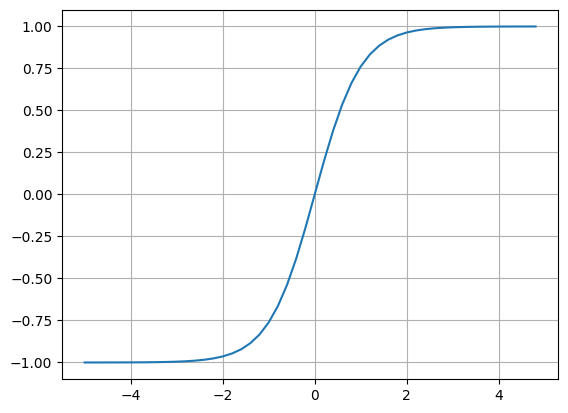

In [ ]:
# lets look at a tanh activation function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.88812, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()



5. Implementing the backward funciton for each operation
- First we can manually calculate gradients for each node
- Also we can modify our class Value adding for each operation function personal _backward function that will calculate gradient for us

In [ ]:
# Manually calculate gradients

# o.grad = 1.0
# n.grad = 1 - o.data**2
# x1w1x2w2.grad = 0.4952
# b.grad = 0.4952
# x1w1.grad = 0.4952
# x2w2.grad = 0.4952
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

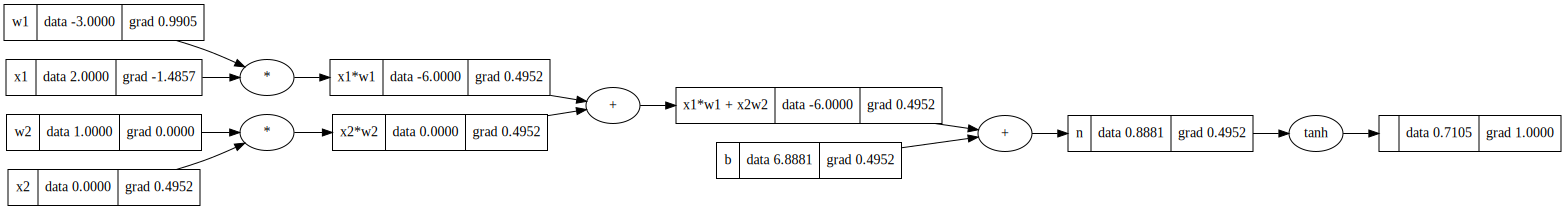

In [ ]:
draw_dot(o)

o = tanh(n)

n.grad = do/dn = 1 - tanh(n)**2

x1w1x2w2.grad = b.grad = n.grad

x1w1.grad = x2w2.grad = x1w1x2w2.grad



In [ ]:
# Automatically calculate each gradient

# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward() # beacause its a leaf node b's backward by initialization is empty function (lambda: None) -> Nothing would happen
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

5. Implementing the backward function for a whole expression graph

Using Topological Sort

Topological Sort is a graph traversal in which each node v is visited only after all its dependencies are visited.

In [ ]:
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo

In [ ]:
# Full code for backward function for a whole expression graph

# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#   node._backward()

In [ ]:
o.backward()